# Data Loading and display of datasets


In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn pycountry

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import plotly.express as px

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.7 MB/s eta 0:00:00


In [ ]:
# Load datasets (replace paths with your actual files)
climate_df = pd.read_csv('/content/drive/MyDrive/climate_change_data.csv')
crop_df = pd.read_csv('/content/drive/MyDrive/crop_production.csv')

# Display basic info
print("Climate Data Shape:", climate_df.shape)
print("\nCrop Data Shape:", crop_df.shape)

# Quick view function
def quick_view(df, name):
    print(f"\n{name} (shape: {df.shape})")
    print("First 3 rows:")
    display(df.head(3))
    print("\nMissing values:")
    print(df.isna().sum()[df.isna().sum() > 0])

# View both datasets
quick_view(climate_df, "CLIMATE DATA")
quick_view(crop_df, "CROP DATA")

Climate Data Shape: (10000, 9)

Crop Data Shape: (20566, 9)

CLIMATE DATA (shape: (10000, 9))
First 3 rows:


,Date,Location,Country,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed
0,2000-01-01 00:00:00.000000000,New Williamtown,Latvia,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026
1,2000-01-01 20:09:43.258325832,North Rachel,South Africa,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300
2,2000-01-02 16:19:26.516651665,West Williamland,French Guiana,27.323718,451.553155,-0.160783,42.697931,96.652600,34.124261



Missing values:
Series([], dtype: int64)

CROP DATA (shape: (20566, 9))
First 3 rows:


,index,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,0,AUS,CROPYIELD,RICE,TONNE_HA,A,1990,8.314607,NaN
1,1,AUS,CROPYIELD,RICE,TONNE_HA,A,1991,8.394737,NaN
2,2,AUS,CROPYIELD,RICE,TONNE_HA,A,1992,8.094340,NaN



Missing values:
Flag Codes    20566
dtype: int64


In [ ]:
# Convert date and extract year
climate_df['year'] = pd.to_datetime(climate_df['Date']).dt.year

# Standardize country names
climate_df['Country'] = climate_df['Country'].str.title().str.strip()

# Aggregate annual climate data
climate_annual = climate_df.groupby(['Country', 'year']).agg({
    'Temperature': 'mean',
    'CO2 Emissions': 'mean',
    'Precipitation': 'mean',
    'Humidity': 'mean'
}).reset_index()

In [ ]:
# Convert date and extract year
climate_df['year'] = pd.to_datetime(climate_df['Date']).dt.year

# Standardize country names
climate_df['Country'] = climate_df['Country'].str.title().str.strip()

# Aggregate annual climate data
climate_annual = climate_df.groupby(['Country', 'year']).agg({
    'Temperature': 'mean',
    'CO2 Emissions': 'mean',
    'Precipitation': 'mean',
    'Humidity': 'mean'
}).reset_index()

In [ ]:
# Convert country codes to names
def code_to_name(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return code

crop_df['Country'] = crop_df['LOCATION'].apply(code_to_name)

# Filter for specific crop (e.g., rice)
rice_df = crop_df[crop_df['SUBJECT'] == 'RICE'].copy()

# Aggregate annual crop data
rice_annual = rice_df.groupby(['Country', 'TIME']).agg({
    'Value': 'mean'
}).rename(columns={'Value': 'Rice_Yield', 'TIME': 'year'}).reset_index()

In [ ]:
print("Climate Data Columns:", climate_annual.columns.tolist())
print("Rice Data Columns:", rice_annual.columns.tolist())

Climate Data Columns: ['Country', 'year', 'Temperature', 'CO2 Emissions', 'Precipitation', 'Humidity']
Rice Data Columns: ['Country', 'TIME', 'Rice_Yield']


# The problem is that  rice data uses 'TIME' instead of 'year' as the column name for years.

In [ ]:
# Rename the 'TIME' column to 'year' in the rice data to match climate data
rice_annual = rice_annual.rename(columns={'TIME': 'year'})

# Now merge will work
merged_df = pd.merge(
    climate_annual,
    rice_annual,
    on=['Country', 'year'],
    how='inner'  # keeps only matching records
)

print("\nSuccessfully merged data shape:", merged_df.shape)
print(merged_df.head())


Successfully merged data shape: (698, 7)
   Country  year  Temperature  CO2 Emissions  Precipitation   Humidity  \
0  Algeria  2000    10.061366     411.329160      41.163857  14.344537   
1  Algeria  2001    13.723152     428.581686      22.862543  49.318371   
2  Algeria  2002    25.468400     331.691315      98.719375  63.978270   
3  Algeria  2003    14.573611     382.129840      45.671625  39.276534   
4  Algeria  2004    17.793835     451.609818      43.747840  18.737865   

   Rice_Yield  
0         0.8  
1         0.8  
2         0.8  
3         0.8  
4         0.8  


# Exploratory Data Analysis(EDA)

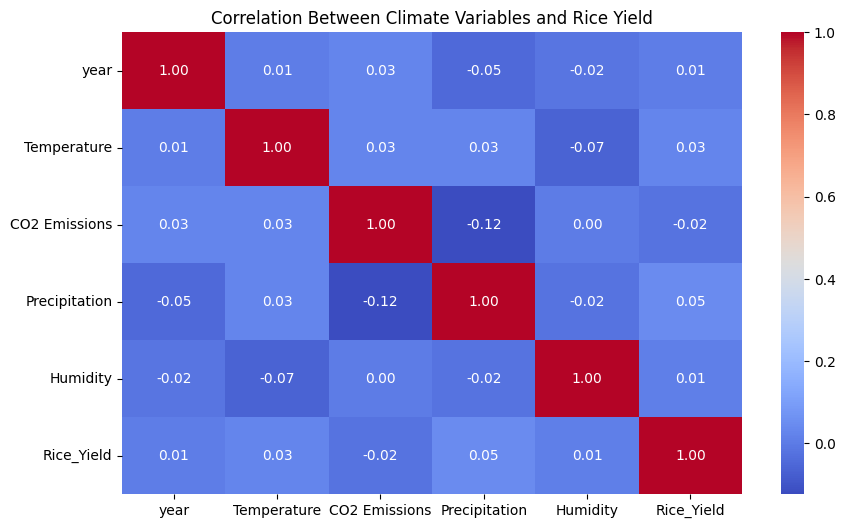

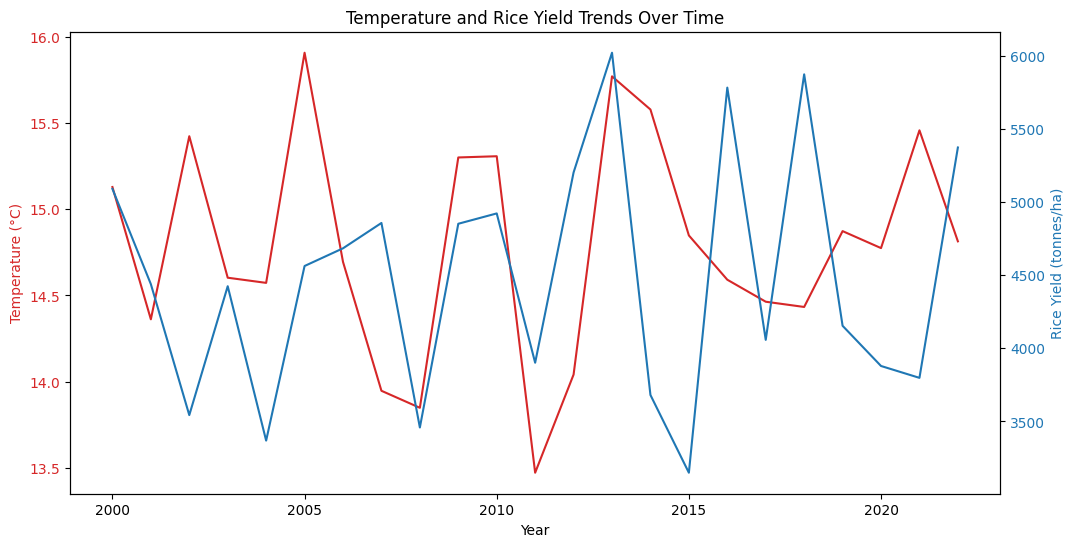

In [ ]:
# Correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Climate Variables and Rice Yield')
plt.show()

# Time series trends
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(merged_df.groupby('year')['Temperature'].mean(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Rice Yield (tonnes/ha)', color=color)
ax2.plot(merged_df.groupby('year')['Rice_Yield'].mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Temperature and Rice Yield Trends Over Time')
plt.show()

# Featured Engineering

In [ ]:
# Calculate extreme weather indicators
merged_df['Heat_Days'] = np.where(merged_df['Temperature'] > 30, 1, 0)
merged_df['Dry_Spells'] = np.where(merged_df['Precipitation'] < 20, 1, 0)

# Select final features
features = ['Temperature', 'CO2 Emissions', 'Precipitation', 'Humidity', 'Heat_Days', 'Dry_Spells']
X = merged_df[features]
y = merged_df['Rice_Yield']

Model training with Random Forest

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

Model Evaluation

Model Performance:
- RMSE: 11933.000
- R² Score: -0.092


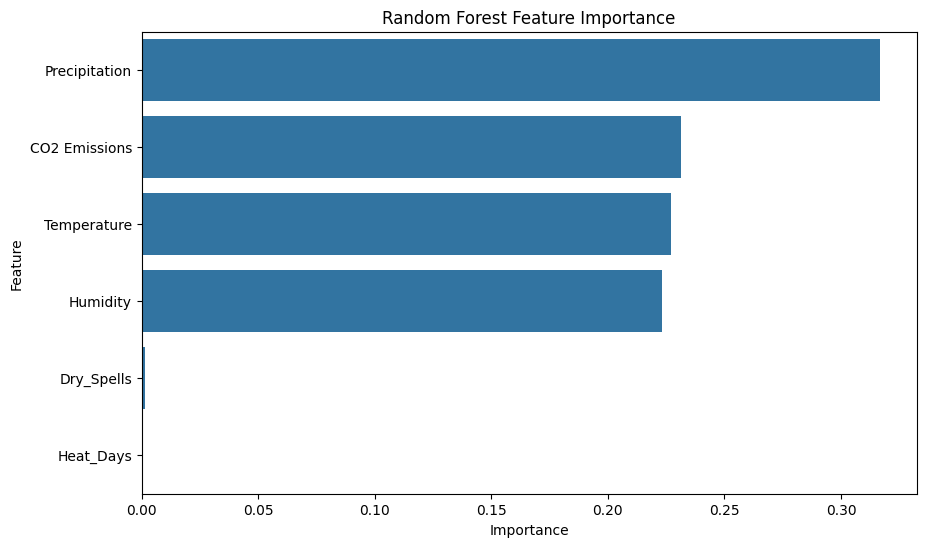

In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"- RMSE: {rmse:.3f}")
print(f"- R² Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.show()

# Permutation Importance

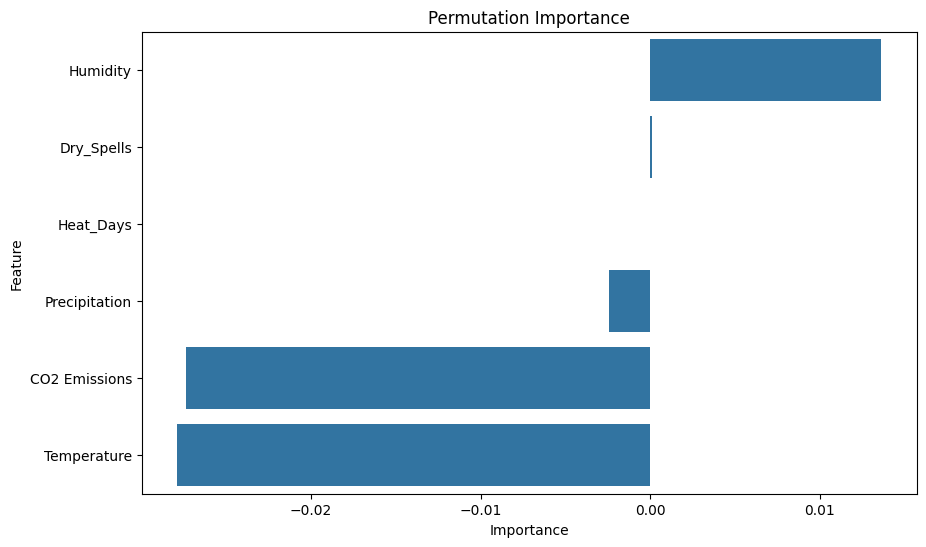

In [ ]:
# Calculate permutation importance
result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42
)

perm_importance = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance, x='Importance', y='Feature')
plt.title('Permutation Importance')
plt.show()

# Climate Impact Projections

In [ ]:

# Create climate scenarios
current = X_train.mean().to_frame().T
warming_1c = current.copy()
warming_2c = current.copy()
warming_1c['Temperature'] += 1
warming_2c['Temperature'] += 2

# Predict yields
current_yield = rf_model.predict(current)[0]
warming_1c_yield = rf_model.predict(warming_1c)[0]
warming_2c_yield = rf_model.predict(warming_2c)[0]

# Calculate impacts
impact_1c = (warming_1c_yield - current_yield) / current_yield * 100
impact_2c = (warming_2c_yield - current_yield) / current_yield * 100

print("\nProjected Climate Change Impacts:")
print(f"- At +1°C: {impact_1c:.1f}% change in rice yield")
print(f"- At +2°C: {impact_2c:.1f}% change in rice yield")


Projected Climate Change Impacts:
- At +1°C: -4.0% change in rice yield
- At +2°C: -16.9% change in rice yield


# Analysis according to specific country

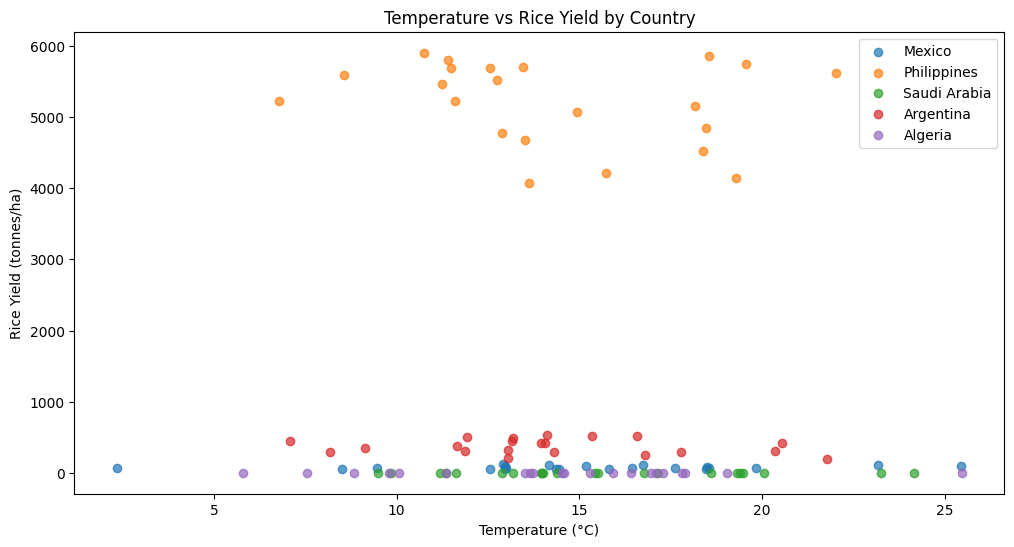

In [ ]:
# Select top 5 countries
top_countries = merged_df['Country'].value_counts().index[:5]

# Plot climate-yield relationships
plt.figure(figsize=(12, 6))
for country in top_countries:
    country_data = merged_df[merged_df['Country'] == country]
    plt.scatter(
        country_data['Temperature'],
        country_data['Rice_Yield'],
        label=country,
        alpha=0.7
    )

plt.xlabel('Temperature (°C)')
plt.ylabel('Rice Yield (tonnes/ha)')
plt.legend()
plt.title('Temperature vs Rice Yield by Country')
plt.show()

# Saving for futurte use

In [ ]:
import joblib

# Save model
joblib.dump(rf_model, 'climate_impact_rf_model.pkl')

# Save processed data
merged_df.to_csv('processed_climate_crop_data.csv', index=False)

print("Project artifacts saved successfully!")

Project artifacts saved successfully!
